In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from chainconsumer import ChainConsumer
from sbi_lens.config import config_lsst_y_10
import haiku as hk
from functools import partial
from sbi_lens.normflow.models import ConditionalRealNVP, AffineSigmoidCoupling, AffineCoupling
import numpyro.distributions as dist
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions
from haiku._src.nets.resnet import ResNet18
import pickle

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# plot params

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["lines.linewidth"] = 1
plt.rcParams['lines.markersize'] = 3
color = [
    '#FF8F00',
    '#FD5F00',
    '#00204A',
    '#005792',
    '#8AD5E6',
    "#111111",
    '#FD5F00'
]

In [3]:
# params

seed_store = [2,3,4,5]
n = 100_000
m = 10_000


dim = 6
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
lr_schedule = 'exp_decay'
total_steps = 70_000
sbi_method = "nle"
nf_type = "affine"
bs = 56

truth = config_lsst_y_10.truth
params_name = config_lsst_y_10.params_name_latex

In [4]:
# load all required data

dataset = np.load('/gpfswork/rech/eqw/ufa23yn/ssnpe_desc_project/data/LOADED&COMPRESSED_year_10_with_noise_score_density.npz', allow_pickle=True)['arr_0']

m_data = jnp.load('/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/m_data__256N_10ms_27gpa_0.26se.npy')

a_file = open('/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/params_compressor/opt_state_resnet_vmim.pkl', "rb")
opt_state_resnet= pickle.load(a_file)

a_file = open('/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/params_compressor/params_nd_compressor_vmim.pkl', "rb")
parameters_compressor= pickle.load(a_file)

metric_deep_ensemble = pd.read_table("./results/store_experiments.csv", ',')

sample_ff = jnp.load(
  '/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy', allow_pickle=True
)

sample_ps = jnp.load(
  '/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/posterior_power_spectrum__256N_10ms_27gpa_0.26se.npy', allow_pickle=True
)

2023-08-11 18:50:55.521365: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfslocalsup/spack_soft/sox/14.4.2/gcc-8.4.1-egb3ni235l3f4q4lxbo3gfqgws6fdecl/lib:/gpfslocalsup/spack_soft/openmpi/4.1.1/gcc-8.5.0-mbafzinnzpvx22cqojowmnmatg2po2aw/lib:/gpfslocalsup/spack_soft/cudnn/8.1.1.33-11.2/gcc-8.3.1-dgsfwc7e23vzc36jopc5nxyunptm2ieh/lib64:/gpfslocalsup/spack_soft/nccl/2.9.6-1/gcc-8.3.1-2c3rwcolksekujszxrg7r72uxmekxx2y/lib:/gpfslocalsys/cuda/11.2/nvvm/lib64:/gpfslocalsys/cuda/11.2/extras/CUPTI/lib64:/gpfslocalsys/cuda/11.2/lib64:/gpfslocalsys/cuda/11.2/samples/common/lib/linux/x86_64:/gpfslocalsys/cuda/11.2/targets/x86_64-linux/lib:/gpfslocalsys/slurm/current/lib/slurm:/gpfslocalsys/slurm/current/lib:/gpfslocalsys/slurm/current/lib/slurm:/gpfslocalsys/slurm/current/lib
2023-08-11 18:50:55.521402: W external/org_tensor

In [5]:
if activ_fun == "silu":
    activ_fun = jax.nn.silu
elif activ_fun == "sin":
    activ_fun = jnp.sin

if nf_type == "smooth":
    if sbi_method == "npe":
        key = jax.random.PRNGKey(0)
        omega_c = dist.TruncatedNormal(0.2664, 0.2, low=0).sample(key, (1000,))
        omega_b = dist.Normal(0.0492, 0.006).sample(key, (1000,))
        sigma_8 = dist.Normal(0.831, 0.14).sample(key, (1000,))
        h_0 = dist.Normal(0.6727, 0.063).sample(key, (1000,))
        n_s = dist.Normal(0.9645, 0.08).sample(key, (1000,))
        w_0 = dist.TruncatedNormal(-1.0, 0.9, low=-2.0, high=-0.3).sample(key, (1000,))

        theta = jnp.stack([omega_c, omega_b, sigma_8, h_0, n_s, w_0], axis=-1)

        scale = jnp.std(theta, axis=0) / 0.07
        shift = jnp.mean(theta / scale, axis=0) - 0.5

    elif sbi_method == "nle":
        # how these qantities are comute (with dataset form prior)
        # scale_y = jnp.std(dataset_y, axis=0) / 0.07
        # shift_y = jnp.mean(dataset_y / scale_y, axis=0) - 0.5

        scale = jnp.array(
            [1.2179337, 1.9040986, 2.070386, 1.9527259, 1.0068599, 0.38351834]
        )
        shift = jnp.array(
            [-0.51705444, -0.39985067, -0.53731424, -0.3843186, -0.5539374, -0.33893403]
        )

    bijector_layers = [128] * n_bijector_layers

    bijector = partial(
        AffineSigmoidCoupling,
        layers=bijector_layers,
        activation=activ_fun,
        n_components=16,
    )

    NF = partial(ConditionalRealNVP, n_layers=n_flow_layers, bijector_fn=bijector)

    class NDE(hk.Module):
        def __call__(self, y):
            nvp = NF(dim)(y)
            return tfd.TransformedDistribution(
                nvp, tfb.Chain([tfb.Scale(scale), tfb.Shift(shift)])
            )

elif nf_type == "affine":
    bijector_layers = [128] * n_bijector_layers

    bijector = partial(AffineCoupling, layers=bijector_layers, activation=activ_fun)

    NF = partial(ConditionalRealNVP, n_layers=n_flow_layers, bijector_fn=bijector)

    class NDE(hk.Module):
        def __call__(self, y):
            return NF(dim)(y)


if nf_type == "affine" and sbi_method == "npe" and score_weight > 0:
    raise ValueError("NDE has to be smooth")


if sbi_method == "npe":
    nf_log_prob = hk.without_apply_rng(
        hk.transform(lambda theta, y: NDE()(y).log_prob(theta).squeeze())
    )
    nf_get_posterior_sample = hk.transform(
        lambda y: NDE()(y).sample(len(sample_ff), seed=hk.next_rng_key())
    )
elif sbi_method == "nle":
    nf_log_prob = hk.without_apply_rng(
        hk.transform(lambda theta, y: NDE()(theta).log_prob(y).squeeze())
    )


def log_prob_fn(params, theta, y):
    return nf_log_prob.apply(params, theta, y)

In [6]:
# functions for the NF mixture

@jax.jit
def compute_mean_log_likelihood(params, mu, batch):
    return jnp.mean(log_prob_fn(params, mu, batch))

def get_sample_from_DE(store_params, store_sample, theta,batch, n):
    likelihood_store = []

    for params in store_params:
        likelihood_store.append(
            compute_mean_log_likelihood(params, theta, batch)
        )
    likelihood_store = jnp.array(likelihood_store)
    likelihood_store_med = jnp.median(likelihood_store)
    likelihood_store = jax.nn.softplus(likelihood_store - likelihood_store_med)
    likelihood_sum = jnp.sum(likelihood_store)
    weight = likelihood_store / likelihood_sum

    cat_samples = tfd.Categorical(probs=weight).sample(n, seed=jax.random.PRNGKey(0))
    unique, counts = np.unique(cat_samples, return_counts=True)
    cat_dict = dict(zip(unique, counts))

    for j,i in enumerate(cat_dict):
        if j == 0:
            weighted_samples = jnp.array(store_sample)[i][:cat_dict[i]]
        else:
            weighted_samples = jnp.concatenate([
                    weighted_samples,
                    jnp.array(store_sample)[i][:cat_dict[i]]
                ],
                axis = 0
            )

    return weighted_samples, weight, cat_dict

@jax.jit
def get_logprob_from_DE(store_params, theta, x, cat):

    distribution_log_probs = [
        log_prob_fn(params, theta.reshape([-1,dim]), x.reshape([-1,dim])) for params in store_params
    ]
    cat_log_probs = jax.nn.log_softmax(cat.logits_parameter())
    final_log_probs = [
        cat_lp + d_lp
        for (cat_lp, d_lp) in zip(cat_log_probs, distribution_log_probs)
    ]
    concat_log_probs = jnp.stack(final_log_probs, 0)
    log_sum_exp =tfp.math.reduce_weighted_logsumexp(concat_log_probs, axis=[0])
    return log_sum_exp

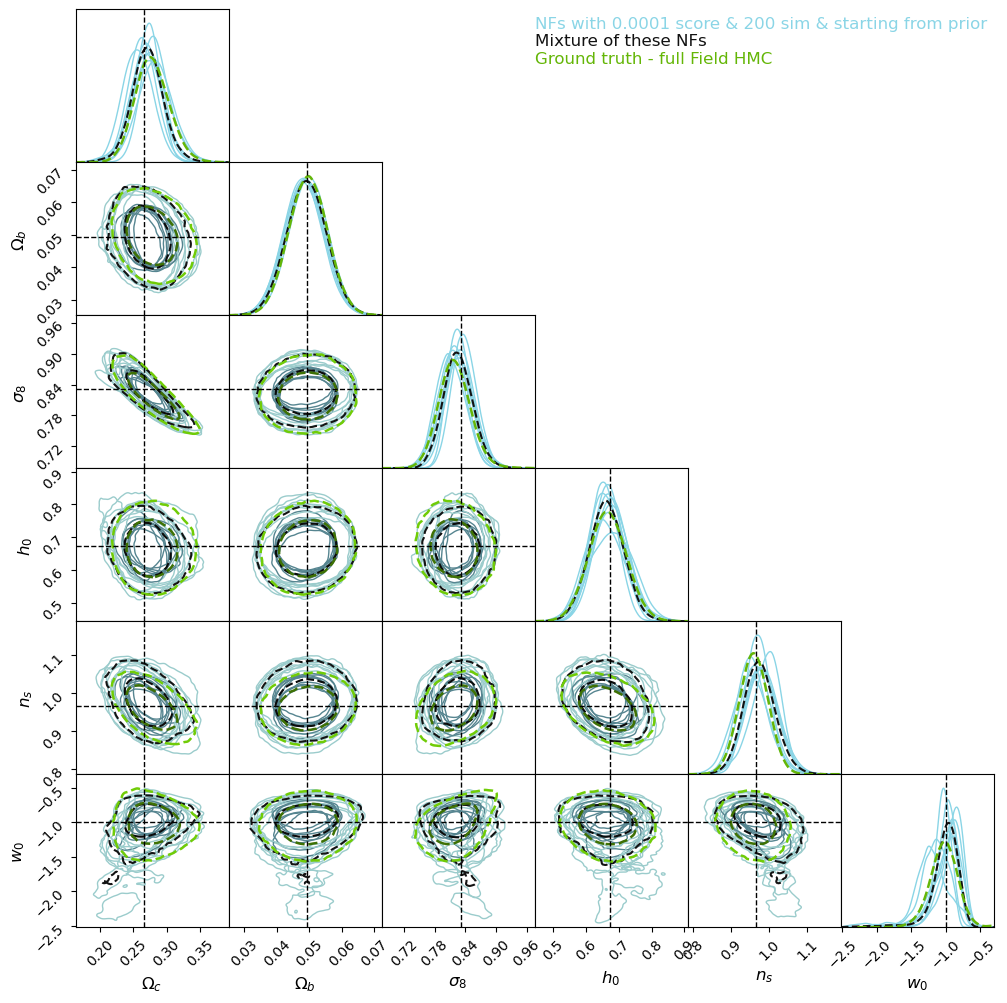

In [8]:
#  Mixture NF
score = 1e-4
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
lr_schedule = 'exp_decay'
total_steps = 70_000
sbi_method = 'nle'
nf_type = 'affine'
bs = 56
seed_store = [2,3,4,5,7,8,9,10,11,12]
tmp = [200]

for nb_simulations in tmp:
    
    for proposal in ['prior']:
        c = ChainConsumer()
        store_posteriors_sample = []
        store_posteriors_params = []
        for seed in seed_store:

            new_table = metric_deep_ensemble.loc[
                        (metric_deep_ensemble['sbi_method'] == sbi_method)  &
                        (metric_deep_ensemble['nf type'] == nf_type)  &
                        (metric_deep_ensemble['batch size'] == bs)  &
                        (metric_deep_ensemble['proposal'] == proposal)  &
                        (metric_deep_ensemble['activ_fun'] == activ_fun)  &
                        (metric_deep_ensemble['lr_schedule'] == lr_schedule) &
                        (metric_deep_ensemble['total_steps'] == total_steps)  &
                        (metric_deep_ensemble['score_weight'] == score)  &
                        (metric_deep_ensemble['n_flow_layers'] == n_flow_layers)  &
                        (metric_deep_ensemble['n_bijector_layers'] == n_bijector_layers) &
                        (metric_deep_ensemble['nb_simulations'] == nb_simulations) &
                        (metric_deep_ensemble['seed'] == seed)
                    ]

            if len(new_table['experiment_id']) != 0:
                exp_id = list(new_table['experiment_id'])[0]

                path1 = './results/experiments/{}/posteriors_sample.npy'.format(str(exp_id))
                path2 = './results/experiments/{}/save_params/params_flow.pkl'.format(str(exp_id))
                posterior_params = np.load(path2, allow_pickle=True)
                posterior_sample = np.load(path1)

                store_posteriors_sample.append(posterior_sample)
                store_posteriors_params.append(posterior_params)

                c.add_chain(
                    posterior_sample,
                    parameters=params_name,
                    name='NFs with {} score & {} sim & starting from {}'.format(score, nb_simulations, proposal),
                    shade_alpha = 0.2,
                    color = color[4]
                )

        if len(jnp.array(store_posteriors_sample)) !=0:
            ref_posterior, weight, cat_dict = get_sample_from_DE(
                store_posteriors_params,
                store_posteriors_sample,
                dataset.item()['theta'][:m],
                dataset.item()['y'][:m],
                n
            )

            c.add_chain(
                ref_posterior,
                parameters=params_name,
                name='Mixture of these NFs',
                shade_alpha = 0.2,
                color = color[5],
                linewidth=1.5,
                linestyle = '--'
            )

        c.add_chain(
            sample_ff,
            parameters=params_name,
            name='Ground truth - full Field HMC',
            shade_alpha = 0.2,
            color = '#64B607',
            linewidth=1.8,
            linestyle = '--'
        )

        fig = c.plotter.plot(
            figsize=1.2,
            truth=truth,
        )

<Figure size 1500x800 with 0 Axes>

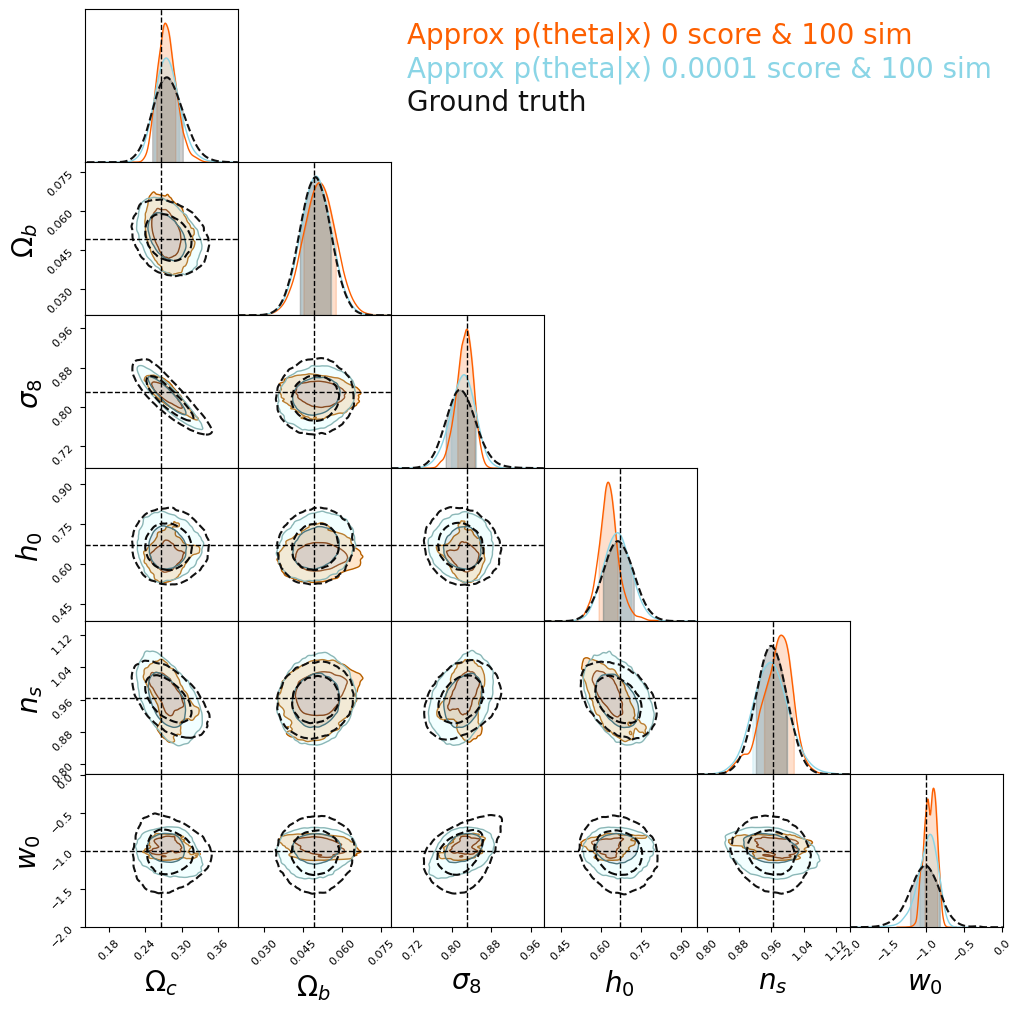

<Figure size 1500x800 with 0 Axes>

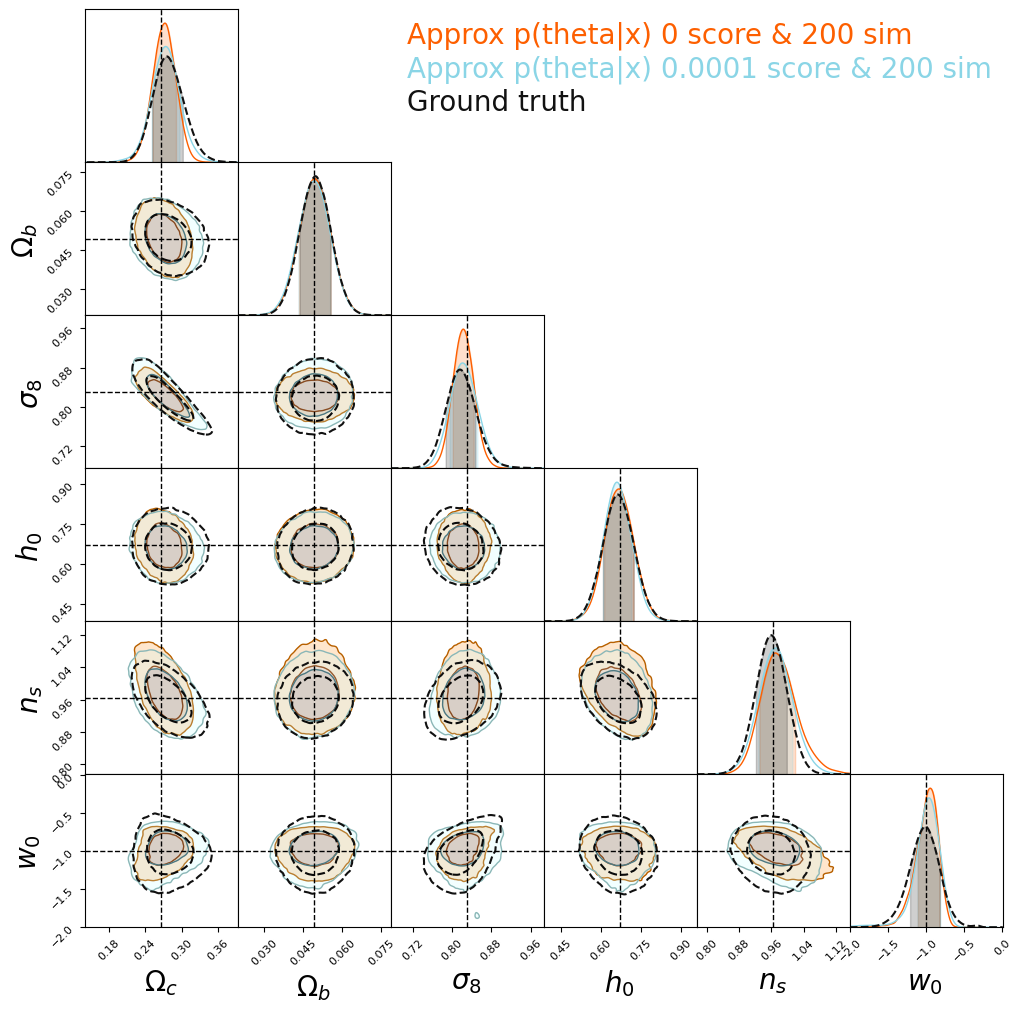

<Figure size 1500x800 with 0 Axes>

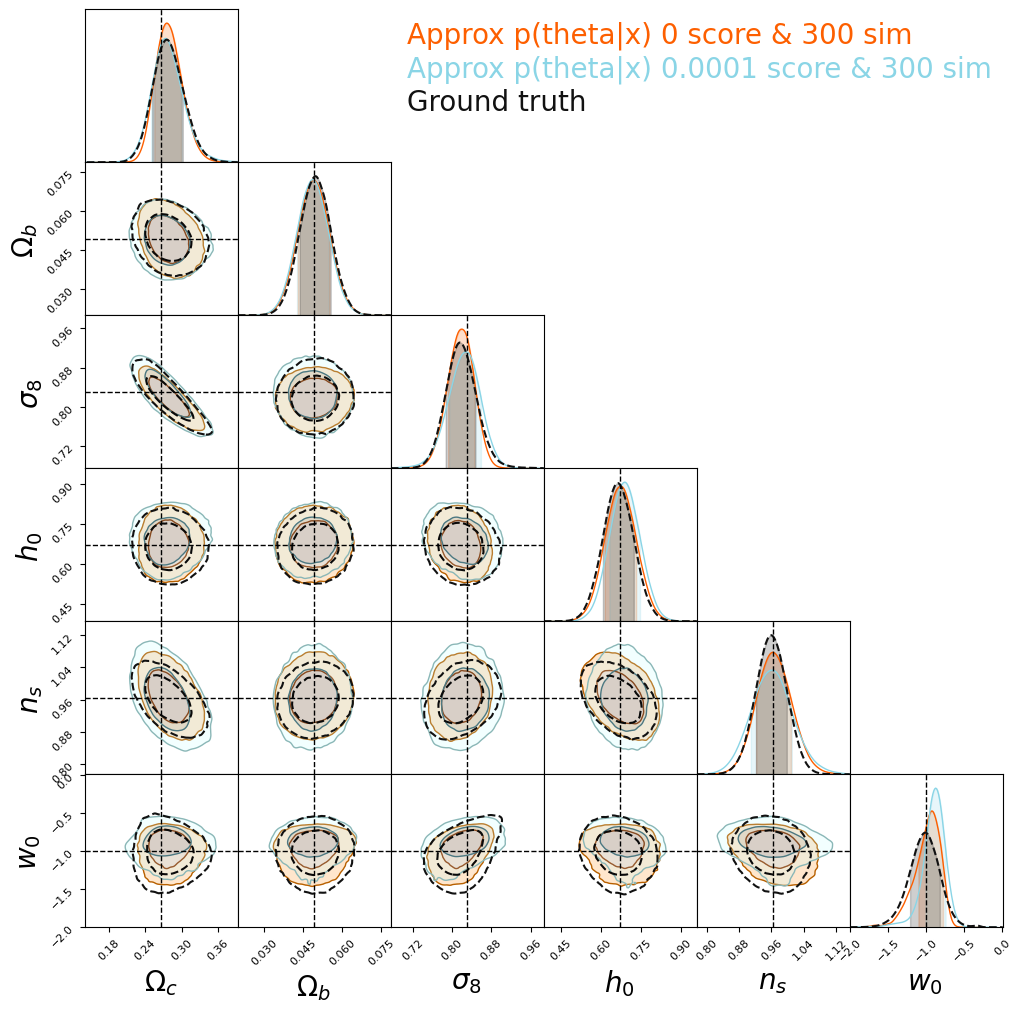

<Figure size 1500x800 with 0 Axes>

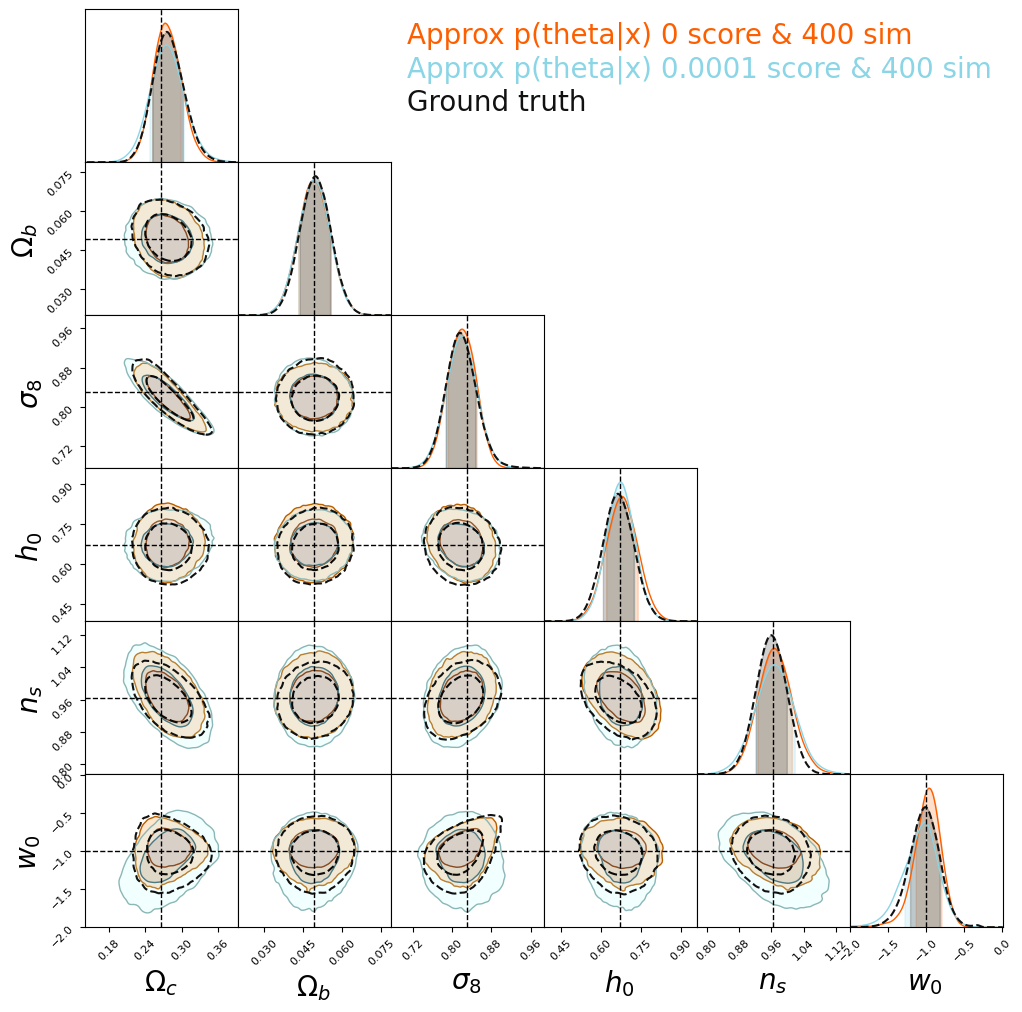

<Figure size 1500x800 with 0 Axes>

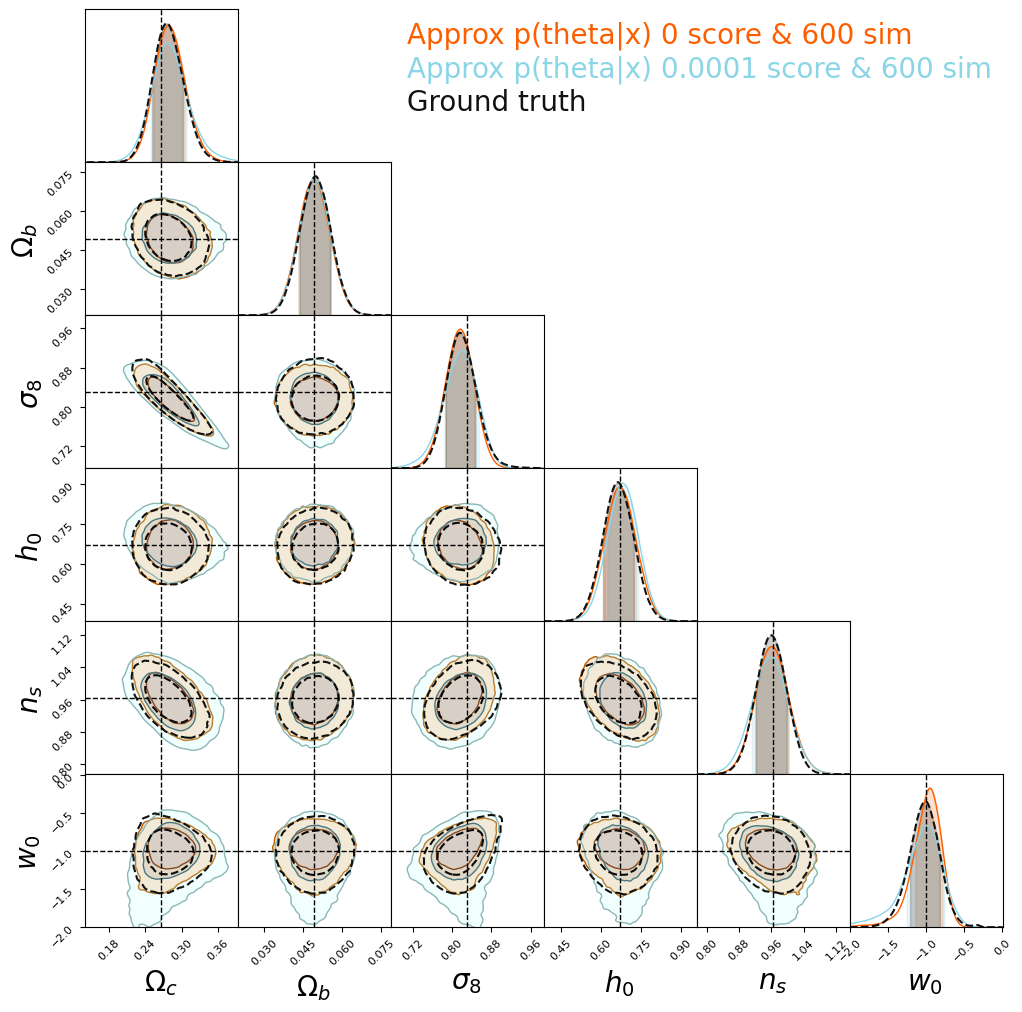

<Figure size 1500x800 with 0 Axes>

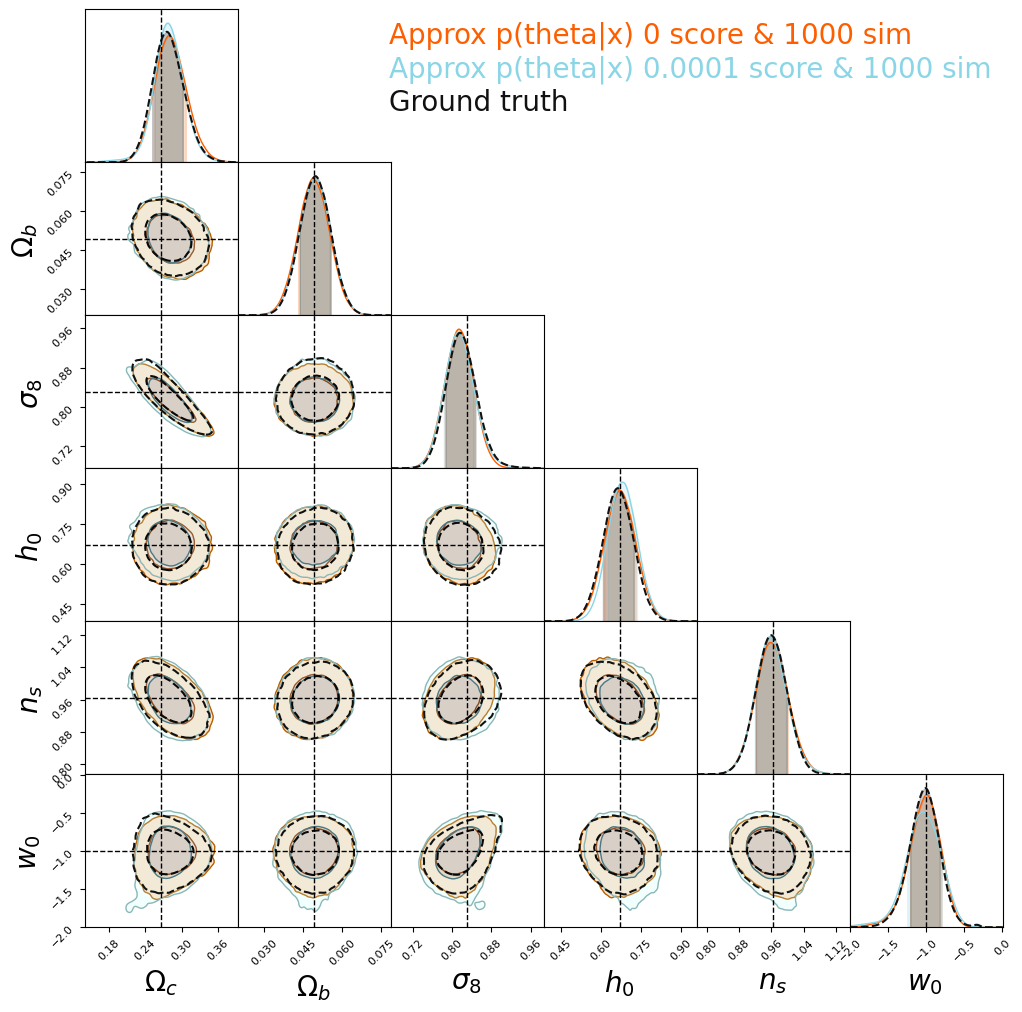

In [7]:
proposal = "prior"

colmap = ['#FD5F00', '#8AD5E6', '#DE3163', '#64B607']
shade = len(colmap) * [0.2]
tmp = [100,200,300,400,600,1000]
tmp[0] = 100

dim = 6
n_flow_layers = 4
n_bijector_layers = 2
activ_fun = 'silu'
lr_schedule = 'exp_decay'
total_steps = 70_000
sbi_method = "nle"
nf_type = "affine"
bs = 56
seed_store = [2,3,4,5,6,7,8,9,10,11,12]

for nb_simulations in tmp:
    plt.figure()
    c = ChainConsumer()
    i = 0
    for score in [0, 1e-4]:

        store_posteriors_sample_without_score = []
        store_posteriors_params_without_score = []
        for seed in seed_store:

            new_table = metric_deep_ensemble.loc[
                (metric_deep_ensemble['sbi_method'] == sbi_method)  &
                (metric_deep_ensemble['nf type'] == nf_type)  &
                (metric_deep_ensemble['batch size'] == bs)  &
                (metric_deep_ensemble['proposal'] == proposal)  &
                (metric_deep_ensemble['activ_fun'] == activ_fun)  &
                (metric_deep_ensemble['lr_schedule'] == lr_schedule) &
                (metric_deep_ensemble['total_steps'] == total_steps)  &
                (metric_deep_ensemble['score_weight'] == score)  &
                (metric_deep_ensemble['n_flow_layers'] == n_flow_layers)  &
                (metric_deep_ensemble['n_bijector_layers'] == n_bijector_layers) &
                (metric_deep_ensemble['nb_simulations'] == nb_simulations) &
                (metric_deep_ensemble['seed'] == seed)
            ]

            if len(new_table['experiment_id']) != 0:
                exp_id = list(new_table['experiment_id'])[0]
                path1 = './results/experiments/{}/posteriors_sample.npy'.format(str(exp_id))
                path2 = './results/experiments/{}/save_params/params_flow.pkl'.format(str(exp_id))
                if os.path.isfile(path2):
                  posterior_params = np.load(path2, allow_pickle=True)
                  posterior_sample = np.load(path1)
                  store_posteriors_sample_without_score.append(posterior_sample)
                  store_posteriors_params_without_score.append(posterior_params)

        posterior_sample, weight, cat_dict = get_sample_from_DE(
                store_posteriors_params_without_score,
                store_posteriors_sample_without_score,
                dataset.item()['theta'][:m],
                dataset.item()['y'][:m],
                n
            )

        c.add_chain(
                posterior_sample,
                parameters=params_name,
                name='Approx p(theta|x) {} score & {} sim'.format(score, nb_simulations),
                shade_alpha =shade[i],
                color = colmap[i]
            )
        i+=1

    c.add_chain(
        sample_ff,
        parameters=params_name,
        name='Ground truth',
        linewidth=1.5,
        color = "#111111",
        shade_alpha = 0,
        linestyle = '--'
    )
    c.configure(legend_kwargs={"fontsize": 20}, tick_font_size=8, label_font_size=20)
    fig = c.plotter.plot(
        figsize=1.2,
        truth=truth,
        extents=[[t - 5 * np.std(sample_ff[:,i]),
                  t + 5 * np.std(sample_ff[:,i])] for i,t in enumerate(truth)]
    )